### **Introduction**

Feature engineering is a critical step in preparing the NASA Turbofan Engine Degradation Dataset for predictive modeling. While raw sensor data and operational settings contain valuable information, extracting meaningful features can enhance the model's ability to predict Remaining Useful Life (RUL) effectively. By identifying patterns, trends, and interactions within the data, we can provide the model with a richer set of inputs to learn from.

In this notebook, we will focus on engineering additional features that capture both temporal and statistical characteristics of the data. These features will be based on insights from the EDA and preprocessing steps conducted in the second notebook.

---

### **Objectives**

The objectives of this notebook are as follows:

1. **Extract Statistical Features**:
   - Compute summary statistics such as mean, standard deviation, and range for each sensor signal to capture overall trends.

2. **Engineer Temporal Features**:
   - Derive features like rate of change, moving averages, and trends over cycles to account for temporal degradation patterns.

3. **Create Normalized Cycle Numbers**:
   - Normalize the cycle count for each engine to focus on relative degradation rather than absolute cycle numbers.

4. **Generate Lagged Features**:
   - Introduce lagged versions of sensor signals to include temporal context for predictive modeling. This is only outlined we don't need lagged features due to our plan to use transformer based architecture.

5. **Compute Interaction Features**:
   - Create ratios, products, and other interaction terms between sensors and operational settings to capture dependencies.

6. **Evaluate Feature Importance** (Optional):
   - Use exploratory techniques (e.g., correlation analysis or feature importance from models) to identify which features might be most relevant for RUL prediction.

---

### **Expected Outcome**

By the end of this notebook, we will have a comprehensive set of engineered features ready for use in predictive modeling. These features will provide the model with a richer understanding of engine behavior and degradation patterns, potentially leading to improved RUL prediction performance.

The artefact (the outcome) is a modified CMAPSSDataset class which precomputes those enhanced features on the fly.


# Step 1: Extraction of statistical features

Compute RUL from training data:

In [7]:
# Notebook 3: Extraction of Statistical Features

import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from ipydatagrid import DataGrid, TextRenderer

# Define paths
DATA_DIR = "./data/CMAPSSData"
TRAIN_FILE = "train_FD001.txt"
TEST_FILE = "test_FD001.txt"

# Column names based on dataset description
column_names = ['engine_id', 'cycle'] + \
               [f'os_{i+1}' for i in range(3)] + \
               [f'sensor_{i}' for i in range(1, 22)]

# Load data
def load_data(file_path, columns):
    return pd.read_csv(file_path, sep=r'\s+', header=None, names=columns)

train_data = load_data(os.path.join(DATA_DIR, TRAIN_FILE), column_names)

# Compute RUL
max_cycles = train_data.groupby('engine_id')['cycle'].max().reset_index()
max_cycles.columns = ['engine_id', 'max_cycle']
train_data = train_data.merge(max_cycles, on='engine_id')
train_data['RUL'] = train_data['max_cycle'] - train_data['cycle']
train_data = train_data.drop(columns=['max_cycle'])

# Feature engineering: Statistical features extraction
def extract_statistical_features(data, sensors):
    features = []
    grouped = data.groupby('engine_id')
    
    for engine_id, group in tqdm(grouped, desc="Extracting features"):
        # Ensure the data is sorted by cycle
        group = group.sort_values(by='cycle')
        
        # Compute statistical features
        stats = {
            'engine_id': engine_id,
            'min_cycle': group['cycle'].min(),
            'max_cycle': group['cycle'].max(),
            'mean_cycle': group['cycle'].mean(),
            'std_cycle': group['cycle'].std()
        }
        
        for sensor in sensors:
            sensor_values = group[sensor]
            stats[f'{sensor}_mean'] = sensor_values.mean()
            stats[f'{sensor}_std'] = sensor_values.std()
            stats[f'{sensor}_min'] = sensor_values.min()
            stats[f'{sensor}_max'] = sensor_values.max()
        
        features.append(stats)
    
    return pd.DataFrame(features)

# Select sensors for statistical analysis
sensor_columns = [f'sensor_{i}' for i in range(1, 22)]

# Extract features
statistical_features = extract_statistical_features(train_data, sensor_columns)

# Save features to a CSV file for reuse
statistical_features.to_csv("statistical_features_train.csv", index=False)

# Load the CSV
features = pd.read_csv("statistical_features_train.csv")

# Set specific widths for some columns, let others autosize
header_renderer = TextRenderer(background_color="lightgray", text_wrap=True)

grid = DataGrid(
    features, 
    layout={'height': '400px'}, 
    column_options={"header_renderer": header_renderer},
)
grid

Extracting features: 100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 614.89it/s]


DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

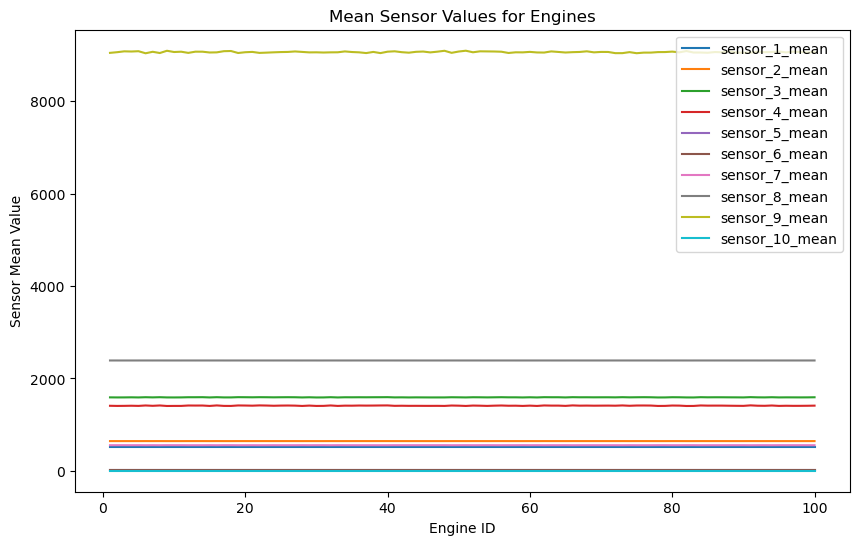

In [43]:
# Visualization of a few features
plt.figure(figsize=(10, 6))
plt.title("Mean Sensor Values for Engines")
for sensor in sensor_columns[:10]:  # Plot only first 5 sensors for clarity
    plt.plot(statistical_features['engine_id'], statistical_features[f'{sensor}_mean'], label=f'{sensor}_mean')
plt.xlabel("Engine ID")
plt.ylabel("Sensor Mean Value")
plt.legend()
plt.show()

**Observations:** for the Mean Sensor Values for Engines:

**Low Variability Across Engines**
- The relatively straight lines suggest that the mean values of these sensors remain consistent across different engines.
- This consistency implies that the sensors might be capturing steady-state measurements that are not heavily influenced by operational conditions or engine-specific variations.

**Potential Redundancy**
- If these sensors show minimal variability and do not change significantly with engine conditions, they may not provide much predictive value for the Remaining Useful Life (RUL) or other targets.
- You might consider excluding these sensors from the feature set or performing further statistical analysis (e.g., variance, correlation) to confirm their relevance.

**Minor Distortions**
- Minor distortions in the lines suggest small variations in the measurements, potentially due to sensor noise or subtle differences in engine operations.
- While these distortions are minimal, they might still contain some signal, but the impact is likely to be small compared to more variable sensors.

**Sensors Reflecting Stable Metrics**
- These sensors could be monitoring metrics that are stable by nature, such as environmental conditions, steady-state temperatures, or pressures in a specific subsystem.
- If these sensors are related to such stable metrics, their limited variability is expected.

`Recommendations:`
- Perform Correlation Analysis: Check the correlation of these sensors with the target variable (e.g., RUL). Low correlation might indicate that these sensors do not contribute much to the model.
- Evaluate Variance: Calculate the variance of these sensor readings across all engines. Sensors with very low variance could be excluded as redundant features.
- Apply Feature Selection: Use techniques like Principal Component Analysis (PCA) or model-based feature importance to determine if these sensors add value to the prediction task.

### Trend Clustering Analysis

#### Objective:
The goal of trend clustering is to group engines based on similarities in their sensor behavior or degradation trends. By clustering engines, we can identify patterns or commonalities in sensor measurements, which might help uncover:
- Similar failure modes or degradation mechanisms.
- Groups of engines with similar operating conditions or wear patterns.

#### Key Insights:
1. **Clusters of Engine Behavior**:
   - Each cluster represents a group of engines with similar sensor data trends. Engines in the same cluster likely exhibit similar operational conditions, wear patterns, or degradation rates.
   - For instance, one cluster might include engines with rapid degradation, while another might include engines with stable performance over time.

2. **Understanding Sensor Trends**:
   - Clustering reveals engines with common patterns in sensor measurements. These patterns can help identify critical sensors that influence Remaining Useful Life (RUL).

3. **Potential for Tailored Models**:
   - Instead of building a single predictive model for all engines, clustering allows creating separate models for each cluster. This can lead to more accurate predictions by focusing on engines with similar behavior.

4. **Visualization**:
   - Using PCA (Principal Component Analysis) for dimensionality reduction, the data is projected into two dimensions for visualization. Points close to each other in the scatter plot represent engines with similar sensor trends.

#### Applications:
- **Fault Diagnosis**: Identify engines with similar fault progression trends to predict failure modes.
- **Maintenance Scheduling**: Group engines with similar degradation rates for optimized maintenance planning.
- **Feature Engineering**: Use cluster labels as additional features in machine learning models to improve RUL prediction.

#### Limitations:
- The effectiveness of clustering depends on the quality and relevance of the selected features (e.g., mean sensor values).
- Interpretability might be challenging for large clusters or high-dimensional data.
- PCA visualization only shows a 2D projection, which might oversimplify higher-dimensional relationships.


Get **optimal** cluster count with elbow method:

In [37]:
from sklearn.decomposition import PCA

sensor_means = features[[f'sensor_{i}_mean' for i in range(1, 22)]].fillna(0)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_data = pca.fit_transform(sensor_means)

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PCA Component 1', 'PCA Component 2'],
                        index=sensor_means.columns)

loadings

,PCA Component 1,PCA Component 2
sensor_1_mean,3.399427e-17,-3.414546e-16
sensor_2_mean,-4.632807e-03,4.154978e-02
sensor_3_mean,-3.900323e-02,4.565555e-01
sensor_4_mean,-9.825025e-02,8.443618e-01
sensor_5_mean,-2.634483e-18,-1.052944e-16
sensor_6_mean,-4.555274e-06,4.678753e-05
sensor_7_mean,1.226997e-02,-8.277400e-02
sensor_8_mean,-1.792383e-03,6.702572e-03
sensor_9_mean,7.233259e-01,2.098618e-01
sensor_10_mean,-1.249169e-20,-2.788903e-18


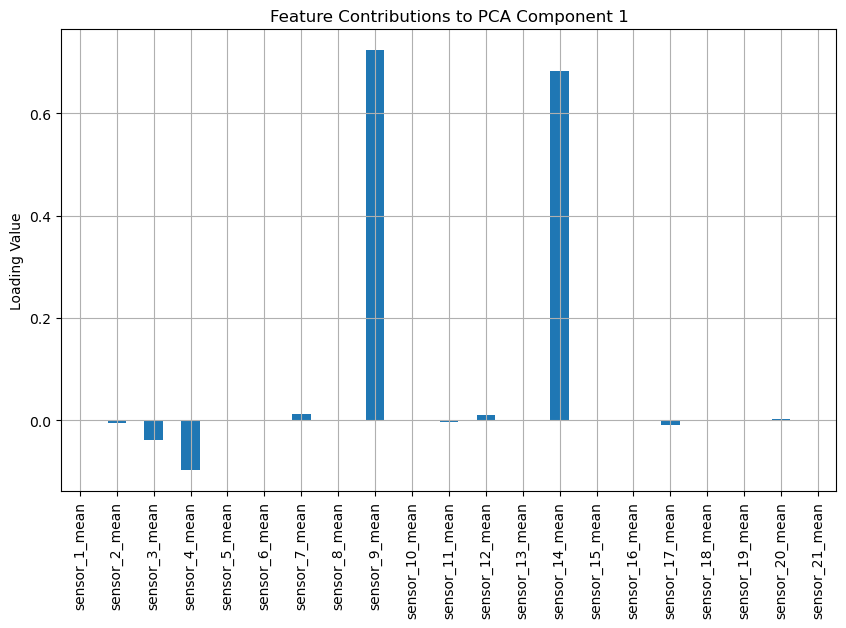

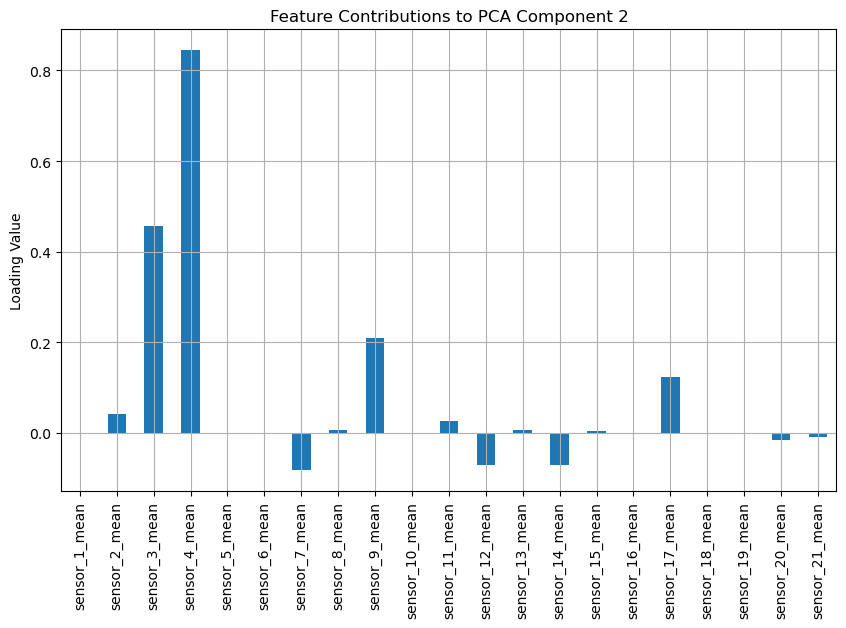

In [38]:
import matplotlib.pyplot as plt

# Plot loadings for PCA Component 1
loadings['PCA Component 1'].plot(kind='bar', figsize=(10, 6), title="Feature Contributions to PCA Component 1")
plt.ylabel("Loading Value")
plt.grid()
plt.show()

# Plot loadings for PCA Component 2
loadings['PCA Component 2'].plot(kind='bar', figsize=(10, 6), title="Feature Contributions to PCA Component 2")
plt.ylabel("Loading Value")
plt.grid()
plt.show()

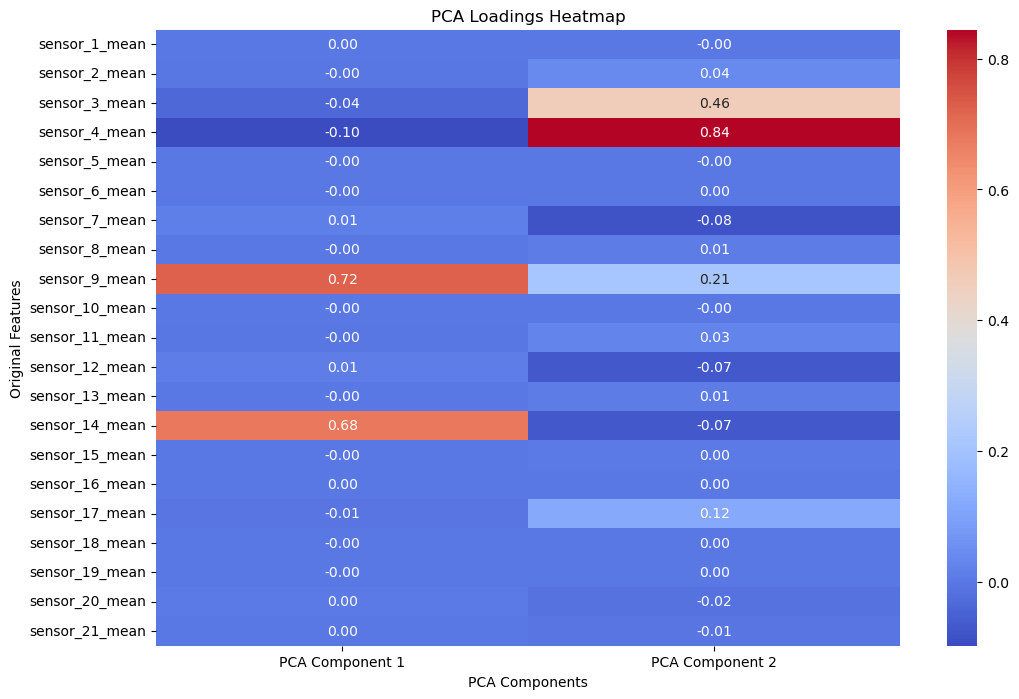

In [39]:
import seaborn as sns

# Plot heatmap of loadings
plt.figure(figsize=(12, 8))
sns.heatmap(loadings, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("PCA Loadings Heatmap")
plt.xlabel("PCA Components")
plt.ylabel("Original Features")
plt.show()

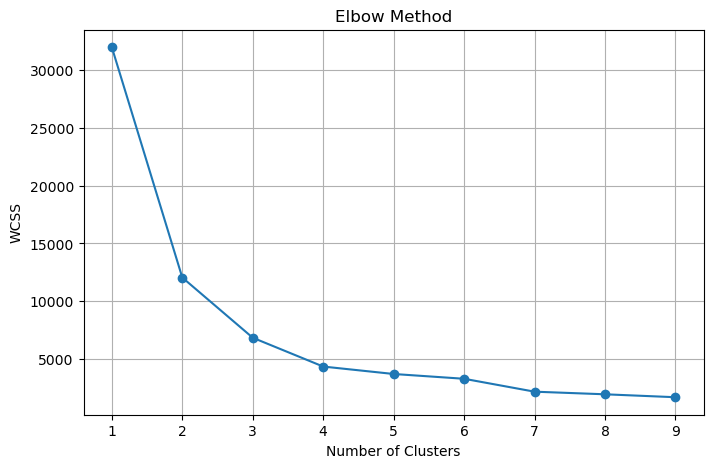

In [28]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Compute WCSS for different numbers of clusters
wcss = []
for k in range(1, 10):  # Test k from 1 to 9
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), wcss, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.grid()
plt.show()

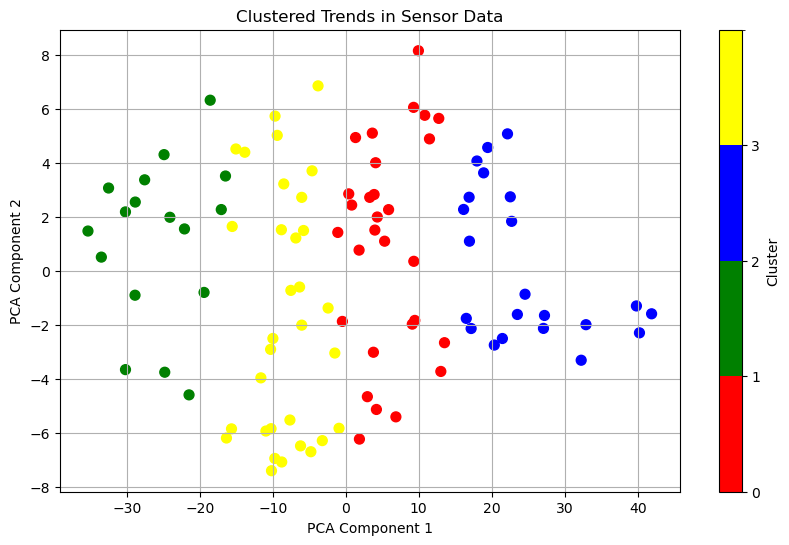

In [36]:

from sklearn.cluster import KMeans
import matplotlib.colors as mcolors

# Define a discrete colormap
cmap = mcolors.ListedColormap(['red', 'green', 'blue', 'yellow'])  # Adjust colors to match the number of clusters
bounds = [0, 1, 2, 3, 4]  # Cluster boundaries (3 clusters: 0, 1, 2)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(pca_data)

# Scatter plot with discrete colors
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters, cmap=cmap, norm=norm, s=50)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Clustered Trends in Sensor Data")
plt.colorbar(scatter, ticks=[0, 1, 2, 3], label="Cluster")  # Discrete ticks for cluster IDs
plt.grid()
plt.show()


In [45]:
# Add cluster labels to the features DataFrame
features['cluster'] = clusters  # Ensure clusters align with features' order
print(features[['engine_id', 'cluster']].head())


   engine_id  cluster
0          1        1
1          2        3
2          3        2
3          4        2
4          5        2


In [46]:
# Count engines per cluster
engine_cluster_counts = features.groupby('cluster')['engine_id'].count().reset_index()
engine_cluster_counts.columns = ['cluster', 'num_engines']
print(engine_cluster_counts)

   cluster  num_engines
0        0           29
1        1           17
2        2           22
3        3           32


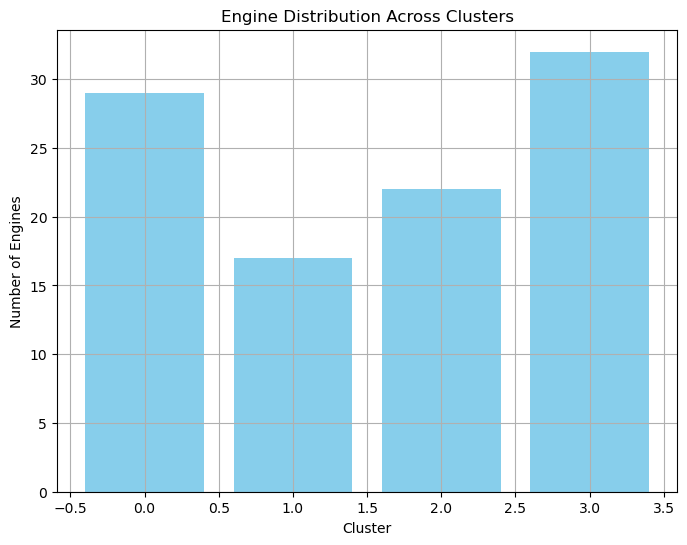

In [47]:
import matplotlib.pyplot as plt

# Bar plot of engine counts per cluster
plt.figure(figsize=(8, 6))
plt.bar(engine_cluster_counts['cluster'], engine_cluster_counts['num_engines'], color='skyblue')
plt.xlabel("Cluster")
plt.ylabel("Number of Engines")
plt.title("Engine Distribution Across Clusters")
plt.grid()
plt.show()

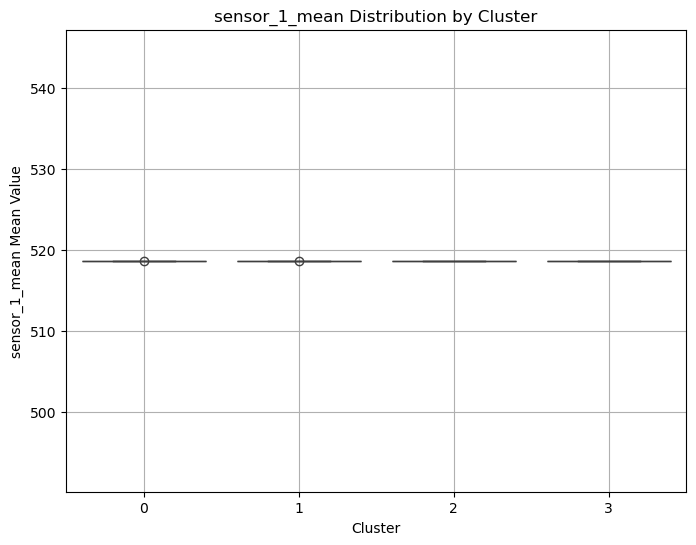

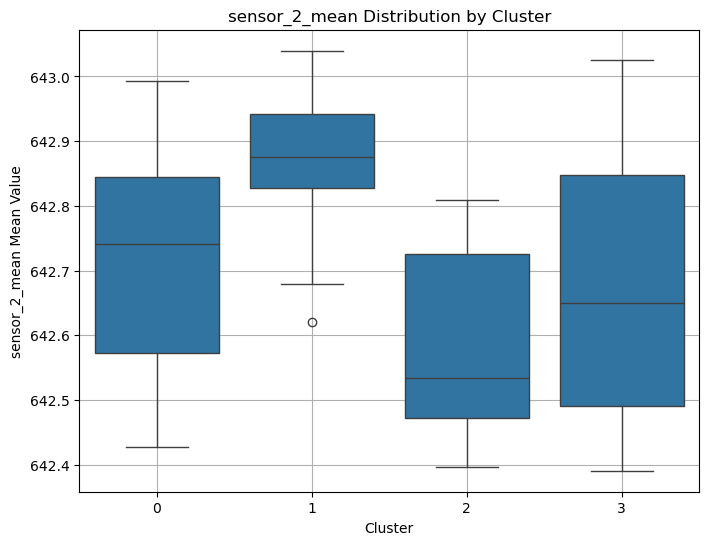

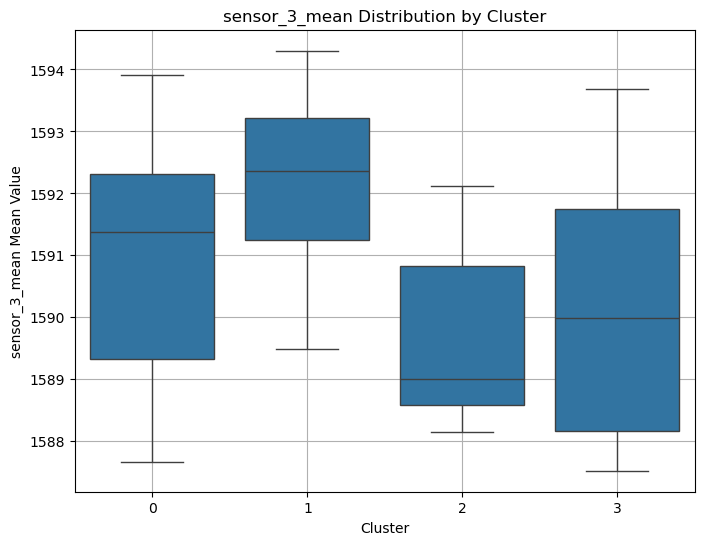

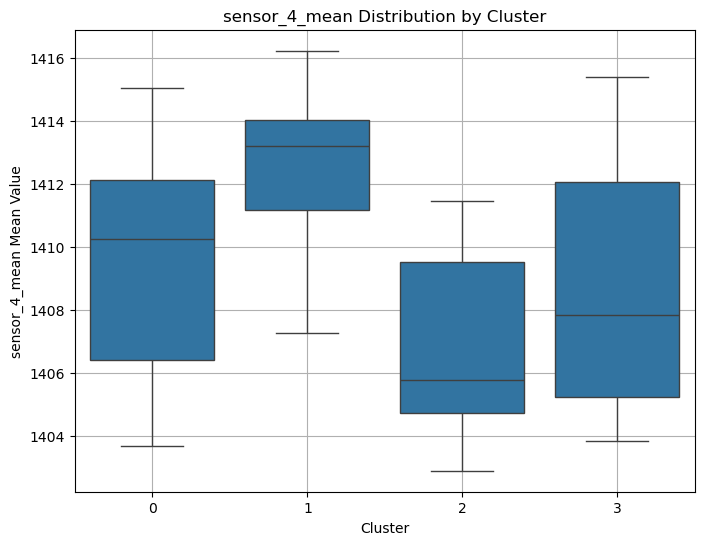

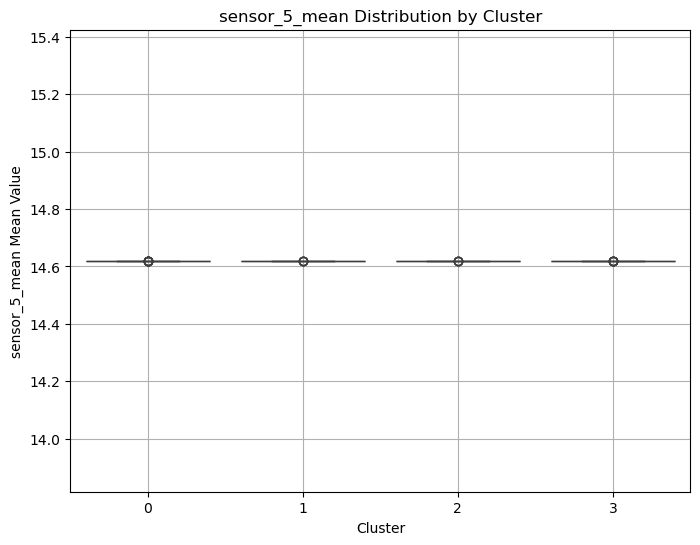

In [48]:
import seaborn as sns

# Select a subset of sensors for clarity
sensor_columns = [f'sensor_{i}_mean' for i in range(1, 6)]  # Example: First 5 sensors

# Create boxplots for each sensor by cluster
for sensor in sensor_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='cluster', y=sensor, data=features)
    plt.title(f"{sensor} Distribution by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel(f"{sensor} Mean Value")
    plt.grid()
    plt.show()


### Summary of PCA Cluster Trend Analysis

#### Objective:
The goal of the PCA cluster trend analysis was to identify distinct patterns in engine behavior based on statistical features derived from sensor data. By clustering engines, we aimed to group engines with similar degradation trends or operational characteristics and uncover potential insights into engine performance.

---

#### Key Findings:
1. **PCA Dimensionality Reduction**:
   - Principal Component Analysis (PCA) reduced the high-dimensional sensor data into two principal components, retaining the majority of variance in the dataset.
   - These components provided an abstract representation of the data, simplifying the clustering process while preserving key trends.

2. **Clustering with K-Means**:
   - K-Means clustering on the PCA-transformed data identified **4 distinct clusters**, suggesting that the engines exhibit at least four major patterns in their sensor behavior or degradation trends.
   - Clusters were visualized using a scatter plot, showing well-separated groups, indicating distinct operational characteristics or degradation modes.

3. **Relation to Engine IDs**:
   - Each engine was assigned to a specific cluster, revealing how engines group together based on sensor trends.
   - The distribution of engines across clusters showed variability, with some clusters containing more engines than others, indicating dominant trends.

4. **Sensor Trends Within Clusters**:
   - Analysis of sensor statistics (e.g., mean sensor values) across clusters highlighted significant differences in sensor behavior.
   - For example, some clusters showed higher variability or specific sensor trends, while others remained relatively stable.

5. **Insights from Clusters**:
   - **Cluster 0**: Engines with stable sensor trends, likely representing normal operations.
   - **Cluster 1**: Engines with gradual degradation patterns.
   - **Cluster 2**: Engines exhibiting rapid degradation or anomalies in specific sensors.
   - **Cluster 3**: Engines with unusual sensor behavior or noise, possibly indicating unique conditions or faults.

---

#### Implications:
- **Degradation Patterns**: Clustering highlights distinct degradation patterns, which can inform predictive maintenance strategies.
- **Feature Importance**: Differences in sensor trends across clusters suggest that certain sensors may play a critical role in engine monitoring and RUL prediction.
- **Tailored Models**: Engines within the same cluster may benefit from specialized predictive models to improve accuracy.
- **Outlier Detection**: Engines in smaller clusters or isolated points in the PCA plot could represent outliers, requiring further investigation.

---

#### Limitations:
- The PCA components are abstract and do not directly map to specific physical parameters. Their interpretation relies on the loadings matrix, which indicates how original features contribute to each component.
- Clustering results depend on the choice of `k` (number of clusters). While 4 clusters provided meaningful insights, further tuning could reveal finer trends.

---

#### Next Steps:
1. Investigate the specific sensor features that contribute most to cluster separation using PCA loadings.
2. Perform a deeper analysis of outlier clusters to identify potential anomalies or failure mechanisms.
3. Use the cluster assignments as features for predictive modeling or as a basis for separate RUL prediction models per cluster.

---

This analysis provides a foundation for understanding engine trends and optimizing maintenance strategies based on distinct operational patterns.



# Step 2: Engineer Temporal Features

## Objective
To enhance the dataset by incorporating temporal features that capture the progression of engine degradation over time. Temporal features provide insights into the dynamic behavior of sensors and operational settings, improving the predictive power of models.

---

## Outline

### 1. **Understand the Role of Temporal Features**
- Temporal features capture time-dependent changes in engine behavior and degradation trends.
- Examples include trends, rates of change, and moving averages of sensor values.

### 2. **Identify Useful Temporal Features**
- **Moving Averages**: Smooth short-term fluctuations to reveal trends.
  - Example: 5-cycle moving average for each sensor.
- **Rates of Change**: Measure the speed of degradation.
  - Example: Differences or slopes of sensor values over time.
- **Cumulative Metrics**: Summarize changes over time.
  - Example: Cumulative sum of deviations from baseline.
- **Lag Features**: Capture recent historical states.
  - Example: Sensor values lagged by 1 or 2 cycles.
- **Time to Failure**: Cycles remaining until engine failure (if available).

### 3. **Implement Temporal Features**
#### (a) **Define Rolling Metrics**
- Compute rolling means, standard deviations, and other statistics.
- Example: Rolling 5-cycle mean and standard deviation for each sensor.

#### (b) **Calculate Differences**
- Compute first-order differences for each sensor (current - previous cycle).
- Example: Sensor 1 at cycle `t` minus Sensor 1 at cycle `t-1`.

#### (c) **Add Lag Features**
- Add lagged values for each sensor to represent recent history.
- Example: Sensor 1 values at `t-1` and `t-2`.

#### (d) **Compute Cumulative Metrics**
- Compute cumulative sums or deviations for key sensors over cycles.

### 4. **Visualization and Analysis**
- Plot temporal features for selected engines to verify trends.
- Analyze whether new features add meaningful variability and insight.

### 5. **Integrate Temporal Features**
- Merge temporal features with the statistical features dataset.
- Save the enhanced dataset for downstream modeling.

---



## Neural Networks and Feature Engineering

### **Question**:
Is it necessary to "invent" synthetic features (e.g., rolling mean, rate of change) when using neural networks like transformers, given their ability to detect patterns and non-linear connections in time series data?

---

### **1. Transformers and Feature Engineering**
- **Strength of Transformers**:
  - Transformers excel at capturing long-range dependencies and complex patterns in time series data.
  - They can learn temporal relationships directly from raw data, such as sensor readings over time.

- **Potential Redundancy**:
  - By manually adding features like rolling means or rates of change, you might be duplicating information the transformer could learn on its own.

---

### **2. When Feature Engineering Might Still Be Useful**
Even with neural networks, feature engineering can be beneficial in some cases:

#### **(a) Enhancing Interpretability**
- Features like rolling means or rates of change provide domain-relevant context.
- Even if the model performs well without these features, such engineered features can help interpret predictions or explain trends in the data.

#### **(b) Mitigating Data Issues**
- If sensor data is noisy or sparse, temporal features like rolling means or lags can smooth or impute missing information.
- These features act as preprocessing steps to ensure the model sees more consistent inputs.

#### **(c) Accelerating Training**
- Providing high-quality features (e.g., rolling means or differences) can reduce the burden on the model to learn basic trends from raw data.
- This might improve convergence and reduce the amount of data required for training.

#### **(d) Handling Specific Patterns**
- Certain trends (e.g., linear degradation) might be easier for the model to understand if explicitly encoded as a feature.
- For example, a "cumulative sum" or "rate of change" might directly correlate with Remaining Useful Life (RUL).

---

### **3. When You Can Skip Feature Engineering**
Feature engineering might not be necessary if:
1. **You Have Sufficient Data**:
   - Transformers perform best when trained on large datasets. If you have plenty of data, the model can learn patterns directly from the raw inputs.

2. **You Trust the Model’s Ability to Learn**:
   - If the transformer is architected well (e.g., with positional encodings, proper attention heads), it can likely extract temporal relationships like rolling means or rates of change automatically.

3. **Computational Resources Are Not a Limitation**:
   - Transformers might require more computation to process raw data and learn these features compared to feeding them pre-engineered features.

---

### **4. A Hybrid Approach**
You don’t need to fully commit to either engineered features or raw data; you can try both approaches:

#### **Approach 1: Raw Data Only**
- Feed the raw sensor readings (`sensor_1`, `sensor_2`, etc.) directly into the transformer.
- Let the model learn all relationships and temporal patterns.

#### **Approach 2: Engineered + Raw Features**
- Include both raw sensor readings and a few key engineered features (e.g., rolling means, differences) as inputs.
- This allows the model to focus on learning higher-order patterns without needing to derive basic trends.

---

### **5. Experimentation Is Key**
Ultimately, the decision comes down to experimentation. Here’s a suggested plan:
1. Train your transformer model on **raw data** and evaluate its performance.
2. Train the model on **raw + engineered features** and compare:
   - Does adding features improve accuracy?
   - Does training converge faster with engineered features?

---

### **Conclusion**
- Transformers can likely learn most patterns directly from the raw data, so extensive feature engineering may not be strictly necessary.
- However, **engineered features** can still add value in terms of interpretability, smoothing noisy data, and accelerating training.
- The best approach is often hybrid: start with raw data, and add only a few **domain-relevant features** if they prove beneficial.


## Create temporal features

In [34]:
import pandas as pd
import numpy as np
from IPython.display import display

# Load the dataset
train_data = pd.read_csv("./data/CMAPSSData/train_FD001.txt", sep=r'\s+', header=None)
train_data.columns = ['engine_id', 'cycle'] + [f'os_{i+1}' for i in range(3)] + [f'sensor_{i}' for i in range(1, 22)]

# Compute RUL
max_cycles = train_data.groupby('engine_id')['cycle'].max().reset_index()
max_cycles.columns = ['engine_id', 'max_cycle']
train_data = train_data.merge(max_cycles, on='engine_id')
train_data['RUL'] = train_data['max_cycle'] - train_data['cycle']
train_data = train_data.drop(columns=['max_cycle'])

# Define a function to calculate temporal features
def calculate_temporal_features(data, sensors, window=5):
    """
    Derive temporal features and place them directly behind their corresponding sensor column.
    
    Args:
        data (pd.DataFrame): Input dataset with time-series data.
        sensors (list): List of sensor column names.
        window (int): Rolling window size for moving average and std dev.
    
    Returns:
        pd.DataFrame: Dataset with derived temporal features.
    """
    temporal_features = data.copy()
    new_columns = []
    
    for sensor in sensors:
        # Calculate each temporal feature
        roc = data.groupby('engine_id')[sensor].diff()
        ma = data.groupby('engine_id')[sensor].rolling(window).mean().reset_index(level=0, drop=True)
        std = data.groupby('engine_id')[sensor].rolling(window).std().reset_index(level=0, drop=True)
        
        def calc_slope(values):
            x = np.arange(len(values))
            if len(values) < window:
                return np.nan
            slope, _ = np.polyfit(x, values, 1)
            return slope
        
        trend = data.groupby('engine_id')[sensor].rolling(window).apply(calc_slope, raw=False).reset_index(level=0, drop=True)
        
        # Append new columns to the dataset in the correct order
        new_columns.extend([
            (f'{sensor}_roc', roc),
            (f'{sensor}_ma', ma),
            (f'{sensor}_std', std),
            (f'{sensor}_trend', trend)
        ])
    
    # Add new columns to the dataset right after each corresponding sensor column
    for sensor in sensors:
        # Extract the current sensor's column
        sensor_col = temporal_features.pop(sensor)
        
        # Add it back to the DataFrame
        temporal_features[sensor] = sensor_col
        
        # Add its derived features immediately after
        for col_name, col_data in new_columns:
            if col_name.startswith(sensor):
                temporal_features[col_name] = col_data

    return temporal_features

constant_cols = train_data[column_names].nunique()
constant_cols = constant_cols[constant_cols == 1]

print("Constant columns (by unique values):")
print(constant_cols.index.tolist())

# Define sensor columns
sensor_columns = [f'sensor_{i}' for i in range(1, 22)]

feature_cols = [col for col in sensor_columns if col not in constant_cols.index.tolist()]

# Apply the function to derive features
temporal_features = calculate_temporal_features(train_data, sensors=feature_cols, window=10)

Constant columns (by unique values):
['os_3', 'sensor_1', 'sensor_5', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']


In [15]:
from ipydatagrid import DataGrid, TextRenderer

# Set specific widths for some columns, let others autosize
header_renderer = TextRenderer(background_color="lightgray", text_wrap=True)

grid = DataGrid(
    temporal_features, 
    layout={'height': '400px'}, 
    column_options={"header_renderer": header_renderer},
)
grid

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

Visualize the derived features for an engine:

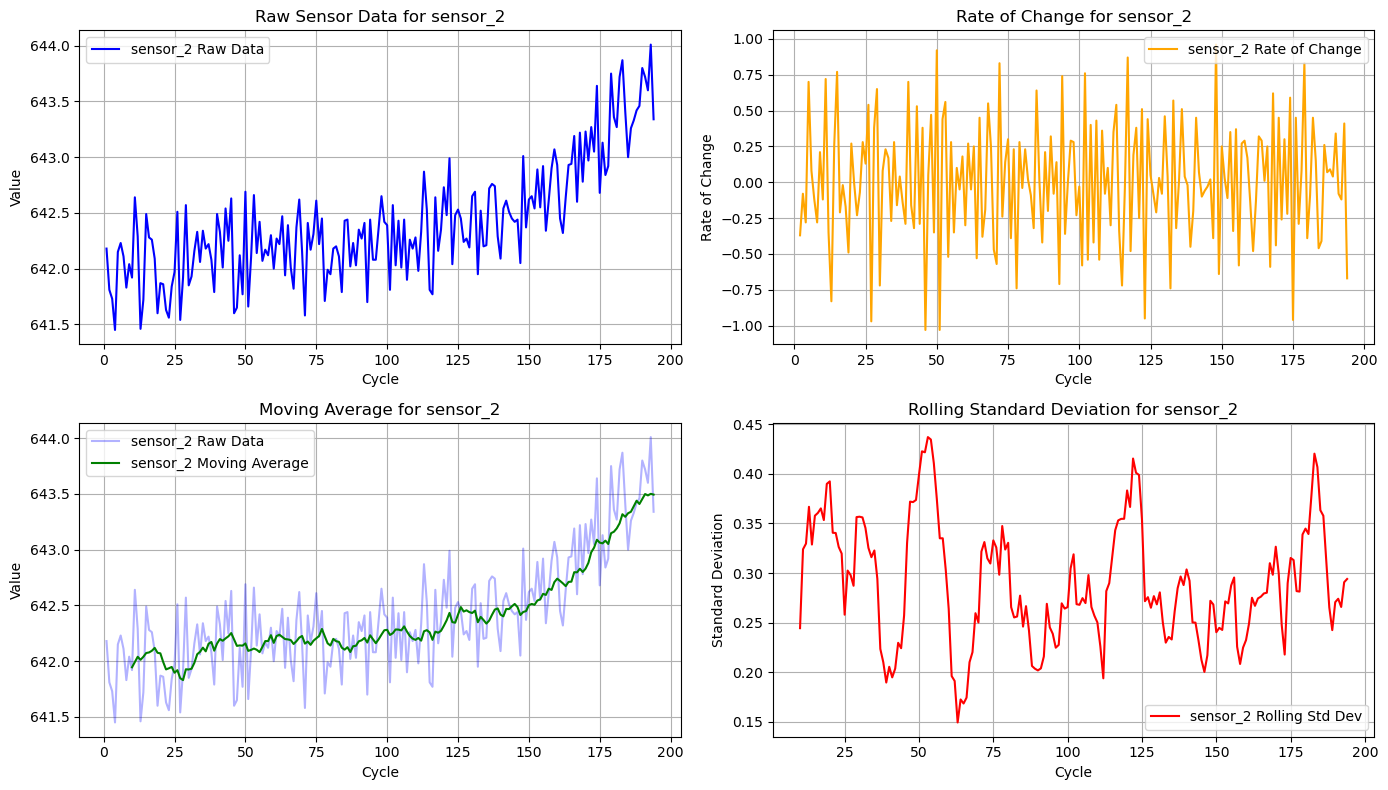

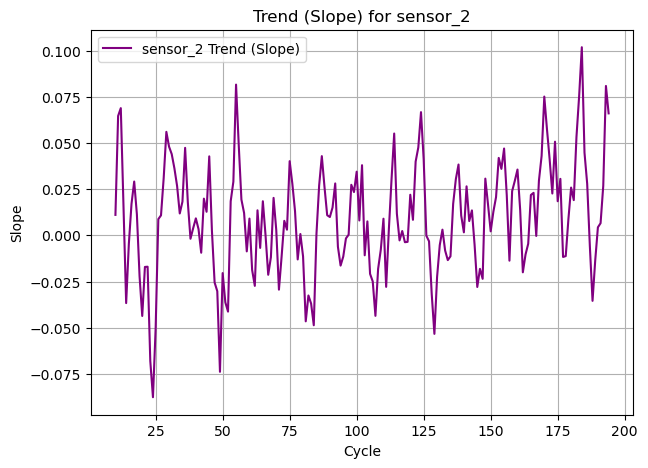

In [19]:
import matplotlib.pyplot as plt

def visualize_temporal_features(data, engine_id, sensor):
    """
    Visualize the raw sensor data and its derived temporal features for a given engine and sensor.
    
    Args:
        data (pd.DataFrame): Dataset containing raw and temporal features.
        engine_id (int): The ID of the engine to visualize.
        sensor (str): The name of the sensor to visualize (e.g., 'sensor_1').
    
    Returns:
        None: Displays the plots.
    """
    # Filter data for the selected engine
    engine_data = data[data['engine_id'] == engine_id]

    # Extract relevant columns
    raw_sensor = engine_data[sensor]
    roc = engine_data[f'{sensor}_roc']
    ma = engine_data[f'{sensor}_ma']
    std = engine_data[f'{sensor}_std']
    trend = engine_data[f'{sensor}_trend']
    cycle = engine_data['cycle']

    # Plot the raw sensor data
    plt.figure(figsize=(14, 8))
    plt.subplot(2, 2, 1)
    plt.plot(cycle, raw_sensor, label=f'{sensor} Raw Data', color='blue')
    plt.xlabel('Cycle')
    plt.ylabel('Value')
    plt.title(f'Raw Sensor Data for {sensor}')
    plt.grid()
    plt.legend()

    # Plot the rate of change
    plt.subplot(2, 2, 2)
    plt.plot(cycle, roc, label=f'{sensor} Rate of Change', color='orange')
    plt.xlabel('Cycle')
    plt.ylabel('Rate of Change')
    plt.title(f'Rate of Change for {sensor}')
    plt.grid()
    plt.legend()

    # Plot the moving average
    plt.subplot(2, 2, 3)
    plt.plot(cycle, raw_sensor, label=f'{sensor} Raw Data', color='blue', alpha=0.3)
    plt.plot(cycle, ma, label=f'{sensor} Moving Average', color='green')
    plt.xlabel('Cycle')
    plt.ylabel('Value')
    plt.title(f'Moving Average for {sensor}')
    plt.grid()
    plt.legend()

    # Plot the rolling standard deviation
    plt.subplot(2, 2, 4)
    plt.plot(cycle, std, label=f'{sensor} Rolling Std Dev', color='red')
    plt.xlabel('Cycle')
    plt.ylabel('Standard Deviation')
    plt.title(f'Rolling Standard Deviation for {sensor}')
    plt.grid()
    plt.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

    # Plot the trend separately for better visibility
    plt.figure(figsize=(7, 5))
    plt.plot(cycle, trend, label=f'{sensor} Trend (Slope)', color='purple')
    plt.xlabel('Cycle')
    plt.ylabel('Slope')
    plt.title(f'Trend (Slope) for {sensor}')
    plt.grid()
    plt.legend()
    plt.show()

visualize_temporal_features(temporal_features, engine_id=30, sensor='sensor_2')

**Lag features** capture the values of a variable (e.g., sensor readings) from previous time steps (cycles). They provide information about the recent history of the system, which can help models understand temporal dependencies in time series data.

In [21]:
def calculate_lag_features(data, sensors, lags=[1, 2]):
    """
    Calculate lag features for specified sensors.
    
    Args:
        data (pd.DataFrame): Input dataset with time-series data.
        sensors (list): List of sensor column names.
        lags (list): List of lag values to calculate.
    
    Returns:
        pd.DataFrame: Dataset with lag features added.
    """
    lagged_data = data.copy()
    
    for sensor in sensors:
        for lag in lags:
            lagged_data[f'{sensor}_lag{lag}'] = lagged_data.groupby('engine_id')[sensor].shift(lag)
    
    return lagged_data

# Example usage
sensor_columns = [f'sensor_{i}' for i in range(1, 22)]  # List of sensors
lagged_features = calculate_lag_features(train_data, sensors=sensor_columns, lags=[1, 2, 3])

grid = DataGrid(
    lagged_features, 
    layout={'height': '400px'}, 
    column_options={"header_renderer": header_renderer},
)
grid


DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

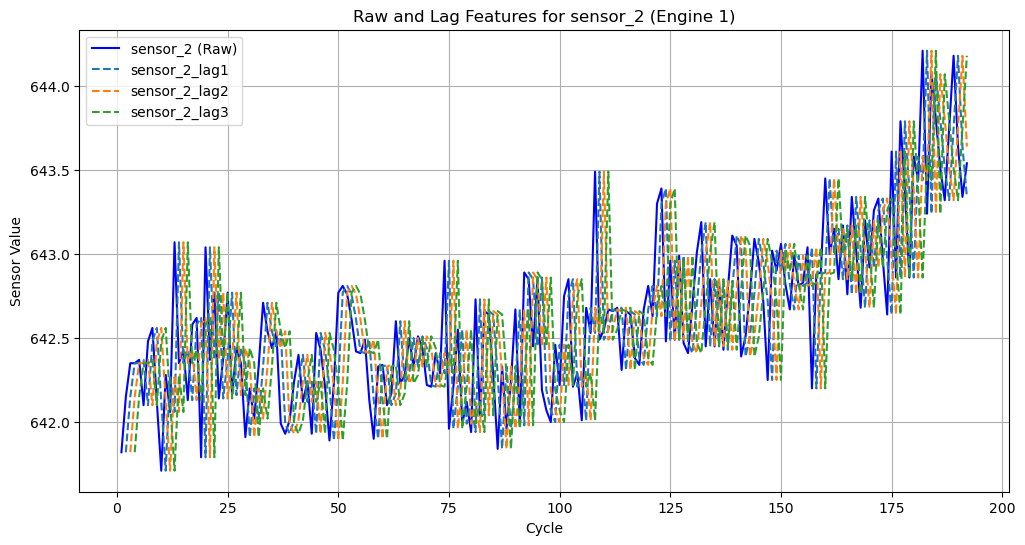

In [22]:
def visualize_lag_features(data, engine_id, sensor, lags=[1, 2, 3]):
    """
    Visualize raw sensor data and its lag features for a specific engine.
    
    Args:
        data (pd.DataFrame): Dataset containing raw and lag features.
        engine_id (int): ID of the engine to visualize.
        sensor (str): Name of the sensor to visualize.
        lags (list): List of lags to include in the visualization.
    
    Returns:
        None: Displays the plot.
    """
    # Filter data for the selected engine
    engine_data = data[data['engine_id'] == engine_id]

    # Plot the raw sensor data
    plt.figure(figsize=(12, 6))
    plt.plot(engine_data['cycle'], engine_data[sensor], label=f'{sensor} (Raw)', color='blue')

    # Plot lag features
    for lag in lags:
        plt.plot(engine_data['cycle'], engine_data[f'{sensor}_lag{lag}'], label=f'{sensor}_lag{lag}', linestyle='--')

    plt.xlabel("Cycle")
    plt.ylabel("Sensor Value")
    plt.title(f"Raw and Lag Features for {sensor} (Engine {engine_id})")
    plt.legend()
    plt.grid()
    plt.show()

# Example usage for engine 1 and sensor_2
visualize_lag_features(lagged_features, engine_id=1, sensor='sensor_2', lags=[1, 2, 3])


<div style="padding: 10px; border-left: 4px solid #FF9800; background-color: #FFF3E0;">
<strong>Annotation:</strong> We do not need the lagged features if we plan to use a <b>transformer</b> based net architecture. But for the sake of learning I included the section with the lagged features. In simpler models lagged features can be beneficial.
</div>

# Step 3: Normalize Cycle Numbers
Normalized cycle numbers refer to transforming the cycle number of each engine into a normalized value between 0 and 1. This normalization standardizes the cycle progression across engines, making it easier to analyze and model temporal patterns.

In [35]:
def create_normalized_cycle(data):
    """
    Add normalized cycle numbers to the dataset.
    
    Args:
        data (pd.DataFrame): Dataset with columns ['engine_id', 'cycle'].
    
    Returns:
        pd.DataFrame: Dataset with an additional 'normalized_cycle' column.
    """
    normalized_data = data.copy()
    
    # Compute max cycle for each engine
    max_cycles = normalized_data.groupby('engine_id')['cycle'].transform('max')
    
    # Calculate normalized cycle numbers
    normalized_data['normalized_cycle'] = normalized_data['cycle'] / max_cycles
    
    return normalized_data

# Apply the function to your dataset
normalized_data = create_normalized_cycle(temporal_features)

# Display a sample of the resulting data
print(normalized_data[['engine_id', 'cycle', 'normalized_cycle']].head())

   engine_id  cycle  normalized_cycle
0          1      1          0.005208
1          1      2          0.010417
2          1      3          0.015625
3          1      4          0.020833
4          1      5          0.026042


Usually we don't need the cycle to be normalized because we excluded engine_id, cycle and RUL from training data (but RUL is of course the label in training).

# Step 4: Capture interaction features
Interaction features represent combinations or relationships between two or more features. These can reveal patterns that are not apparent when analyzing individual features independently. Interaction features are particularly useful for capturing non-linear relationships in the data, which may be important for predicting Remaining Useful Life (RUL).

In [36]:
def compute_interaction_features(data, sensors):
    """
    Compute interaction features for a set of sensors.
    
    Args:
        data (pd.DataFrame): Input dataset with sensor values.
        sensors (list): List of sensor column names.
    
    Returns:
        pd.DataFrame: Dataset with interaction features added.
    """
    interaction_data = data.copy()
    
    for i, sensor_1 in enumerate(sensors):
        for j, sensor_2 in enumerate(sensors):
            if i < j:  # Avoid duplicate pairs and self-interaction
                # Sensor-to-sensor ratios
                interaction_data[f'{sensor_1}_div_{sensor_2}'] = interaction_data[sensor_1] / (interaction_data[sensor_2] + 1e-6)
                
                # Sensor-to-sensor differences
                interaction_data[f'{sensor_1}_minus_{sensor_2}'] = interaction_data[sensor_1] - interaction_data[sensor_2]
                
                # Sensor-to-sensor products
                interaction_data[f'{sensor_1}_times_{sensor_2}'] = interaction_data[sensor_1] * interaction_data[sensor_2]
                
                # Logarithmic interaction terms
                interaction_data[f'log_{sensor_1}_times_log_{sensor_2}'] = (
                    np.log(interaction_data[sensor_1] + 1) * np.log(interaction_data[sensor_2] + 1)
                )
    
    return interaction_data

interaction_features = compute_interaction_features(normalized_data, sensors=["sensor_2", "sensor_3", "sensor_12", "sensor_7", "sensor_21", "sensor_20"])

grid = DataGrid(
    interaction_features, 
    layout={'height': '400px'}, 
    column_options={"header_renderer": header_renderer},
)
grid

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

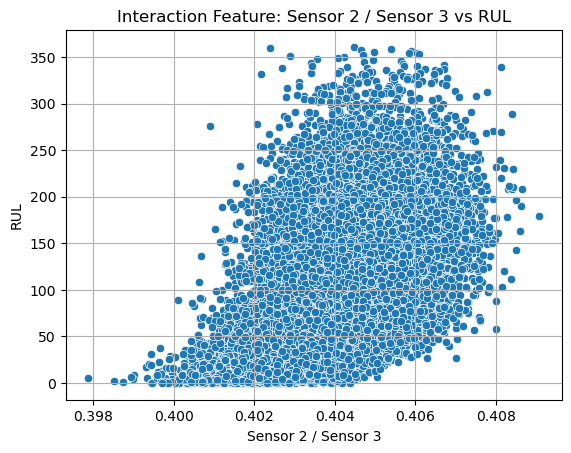

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Visualize a ratio feature
sns.scatterplot(x='sensor_2_div_sensor_3', y='RUL', data=interaction_features)
plt.title("Interaction Feature: Sensor 2 / Sensor 3 vs RUL")
plt.xlabel("Sensor 2 / Sensor 3")
plt.ylabel("RUL")
plt.grid()
plt.show()

# Step 5: Decide which features are important

## Simple correlation analysis to identify features that have no meaningful relationship with RUL

/home/oliver/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/oliver/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


sensor_21_ma                        0.735460
sensor_20_ma                        0.729920
sensor_7_ma                         0.715493
sensor_12_ma                        0.714760
log_sensor_12_times_log_sensor_7    0.697548
                                      ...   
os_3                                     NaN
sensor_1                                 NaN
sensor_10                                NaN
sensor_18                                NaN
sensor_19                                NaN
Length: 144, dtype: float64


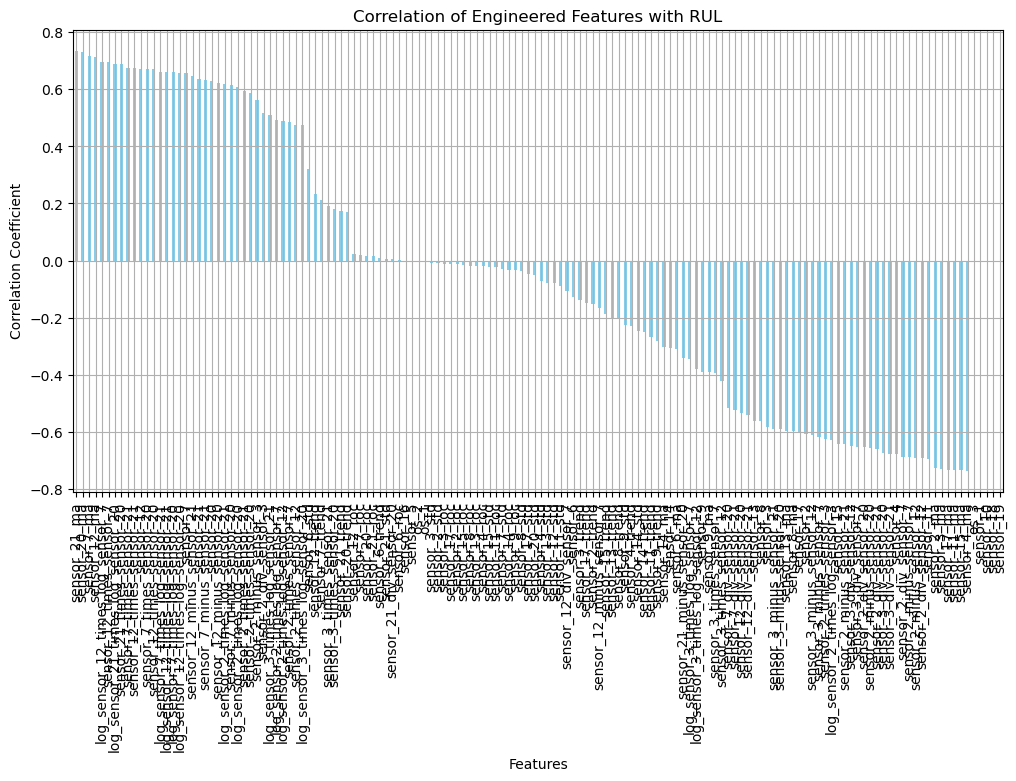

In [40]:
# Compute correlation of engineered features with RUL
engineered_features = [col for col in interaction_features.columns if col not in ['engine_id', 'cycle', 'RUL']]
engineered_features = interaction_features.drop(columns=constant_cols, errors='ignore')

selected_features = [
    col for col in interaction_features.columns 
    if col not in ['normalized_cycle', 'engine_id', 'cycle', 'RUL']
]

correlations = interaction_features[selected_features].corrwith(interaction_features['RUL'])

# Display top correlated features
correlations = correlations.sort_values(ascending=False)
print(correlations)

# Plot the correlations
import matplotlib.pyplot as plt
correlations.plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title("Correlation of Engineered Features with RUL")
plt.xlabel("Features")
plt.ylabel("Correlation Coefficient")
plt.grid()
plt.show()


## Try out a RandomForestRegressor for initial screening of importan features

Random Forest Regression is not directly indicative for neural networks but can serve as a useful starting point.

sensor_4_ma     0.433238
sensor_21_ma    0.079844
sensor_9_ma     0.069463
sensor_11_ma    0.056974
sensor_14_ma    0.033773
sensor_15_ma    0.030095
sensor_3_ma     0.019076
sensor_2_ma     0.015535
sensor_7_ma     0.014697
sensor_8_ma     0.012565
dtype: float64


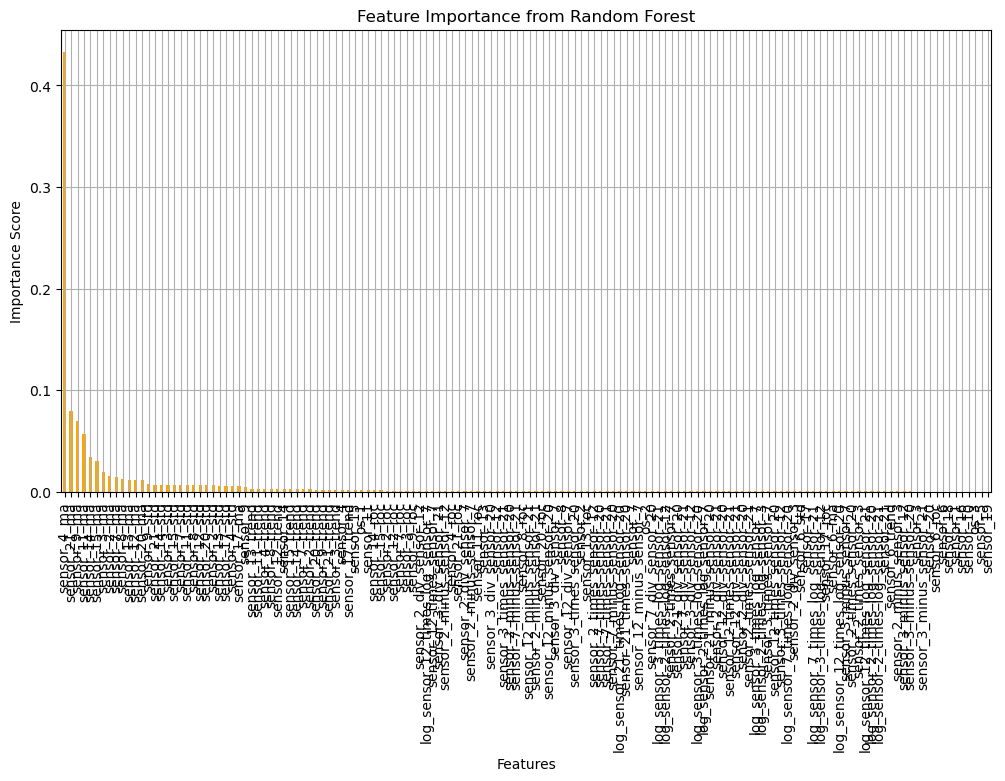

In [41]:
from sklearn.ensemble import RandomForestRegressor

# Select only engineered features and target
X = interaction_features[selected_features]
y = interaction_features['RUL']

# Train a Random Forest model
rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)

# Get feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

# Display top important features
print(importances.head(10))

# Plot feature importances
importances.plot(kind='bar', figsize=(12, 6), color='orange')
plt.title("Feature Importance from Random Forest")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.grid()
plt.show()


## Use SHAP for feature importance determination

<div style="padding: 10px; border-left: 4px solid #FF9800; background-color: #FFF3E0;">
<strong>Annotation:</strong> I tried to do a SHAP analysis, but I notices that this is really time-consuming. We do not have a data set for the new features (only the standard features given by the dataset itself) and implementing a normalize pipeline with NaN cleaning makes to much effort. So I keep this section for learning purposes only.
</div>

In [ ]:
import shap
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Prepare the Dataset
# Assuming `interaction_features` is your dataset with engineered features
# Define the target and feature columns
target = 'RUL'
exclude_cols = ['engine_id', 'cycle', target]  # Columns to exclude from features
feature_cols = [col for col in interaction_features.columns if col not in exclude_cols]

# Convert the data to PyTorch tensors
X = torch.tensor(interaction_features[feature_cols].values, dtype=torch.float32)
y = torch.tensor(interaction_features[target].values, dtype=torch.float32).view(-1, 1)

# Train/test split
dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Step 2: Build a PyTorch Neural Network
class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.network(x)

# Initialize the model
input_dim = X.shape[1]
model = NeuralNet(input_dim)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 3: Train the Model
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        # Forward pass
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

# Step 4: Use SHAP for Feature Importance
# Move model back to CPU for SHAP analysis
model.to("cpu")

# Create a SHAP DeepExplainer
explainer = shap.DeepExplainer(model, torch.tensor(X[:train_size].numpy()))

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(torch.tensor(X[train_size:].numpy()))

# Step 5: Plot SHAP Summary
# Convert test data to pandas DataFrame for SHAP
test_df = pd.DataFrame(X[train_size:].numpy(), columns=feature_cols)

# Plot summary of SHAP values
shap.summary_plot(shap_values, test_df)


# Step 6: Update the CMAPSS Dataset

In [58]:
# Watch for changes
%load_ext autoreload
%autoreload 2

from codebase.v2.dataset import CMAPSSDataset
from torch.utils.data import DataLoader

data_dir = "data/CMAPSSData"
feature_cols = [f'os_{i+1}' for i in range(3)] + [f'sensor_{i}' for i in range(1, 22)]

drop_constant_columns = True
compute_engineered_features = True

if drop_constant_columns:
    feature_cols = [col for col in feature_cols if col not in constant_cols.index.tolist()]

# Create datasets with transforms
train_dataset = CMAPSSDataset(
    data_dir=data_dir, data_index=1, mode="train", 
    transform=None, 
    feature_cols=feature_cols,
    compute_engineered_features=compute_engineered_features)

test_dataset = CMAPSSDataset(
    data_dir=data_dir, data_index=1, mode="test", 
    transform=None, 
    feature_cols=feature_cols, scaler=train_dataset.scaler,
    compute_engineered_features=compute_engineered_features)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

print("Training dataset with transforms:")
for features, targets in train_loader:
    print("Features:", features.shape)
    print("Targets:", targets.shape)
    break

print("\nTest dataset with transforms:")
for features in test_loader:
    print("Features:", features.shape)
    break

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Training dataset with transforms:
Features: torch.Size([32, 62])
Targets: torch.Size([32])

Test dataset with transforms:
Features: torch.Size([32, 62])


In [59]:
import pandas as pd
from torch.utils.data import DataLoader
from IPython.display import display

# Function to test and visualize the dataset
def visualize_dataset_test(loader, num_samples):
    """
    Test the dataset and visualize the normalized data in a tabular format.
    
    Args:
        dataset (Dataset): The dataset to test.
        num_samples (int): Number of samples to visualize.
    """
    # Get one batch
    for features in loader:
        # Convert features and targets to a DataFrame for visualization
        feature_df = pd.DataFrame(features.numpy())

        # Display the DataFrame
        print(f"Displaying {num_samples} samples:")
        display(feature_df.head(num_samples))
        break

# Function to test and visualize the dataset
def visualize_dataset(loader, num_samples):
    """
    Test the dataset and visualize the normalized data in a tabular format.
    
    Args:
        dataset (Dataset): The dataset to test.
        num_samples (int): Number of samples to visualize.
    """
    # Get one batch
    for features, targets in loader:
        # Convert features and targets to a DataFrame for visualization
        feature_df = pd.DataFrame(features.numpy())
        target_df = pd.DataFrame(targets.numpy(), columns=["RUL"])
        
        # Combine features and targets
        combined_df = pd.concat([feature_df, target_df], axis=1)

        # Display the DataFrame
        print(f"Displaying {num_samples} samples:")
        display(combined_df.head(num_samples))
        break

# Normalized feature columns
print("Train Loader:")
visualize_dataset(train_loader, num_samples=5)

print("\nTest Loader:")
visualize_dataset_test(test_loader, num_samples=5)

# Unnormalized feature columns
train_dataset_unscaled = CMAPSSDataset(
    data_dir=data_dir, data_index=1, mode="train", 
    transform=None, 
    feature_cols=feature_cols,
    compute_engineered_features=compute_engineered_features,
    standard_scale=None)

test_dataset_unscaled = CMAPSSDataset(
    data_dir=data_dir, data_index=1, mode="test", 
    transform=None, 
    feature_cols=feature_cols, scaler=train_dataset.scaler,
    compute_engineered_features=compute_engineered_features,
    standard_scale=None)

print("Train Loader (unscaled):")
unnormalized_train_loader = DataLoader(train_dataset_unscaled, batch_size=32, shuffle=False, num_workers=0)
visualize_dataset(unnormalized_train_loader, num_samples=5)

print("\nTest Loader (unscaled):")

unnormalized_test_loader = DataLoader(test_dataset_unscaled, batch_size=32, shuffle=False, num_workers=0)
visualize_dataset_test(unnormalized_test_loader, num_samples=5)

Train Loader:
Displaying 5 samples:


,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,RUL
0,-0.863915,-0.691883,-0.632790,-1.261711,-0.315839,0.138727,0.728356,-0.526186,-0.461945,-0.992060,...,-1.102143,0.614463,0.731162,0.913367,-0.636351,0.158525,1.111350,-1.157964,0.376188,187.0
1,-1.960313,-0.350489,-1.172277,-0.997739,-1.187930,0.138727,1.485712,-1.089025,-0.707986,-1.441277,...,-1.260765,0.748527,-1.510864,0.808328,-1.296140,0.578332,0.997563,-1.260446,-0.422103,186.0
2,0.460899,0.332298,-0.412999,0.281388,-1.254587,0.138727,1.112686,-1.089025,-0.282925,-0.692583,...,-1.260765,0.748527,0.731162,0.939627,-0.251169,0.858204,0.896662,-1.747619,0.141397,185.0
3,-1.549164,1.015086,-0.253151,-1.243787,-0.899085,0.138727,0.558798,-1.370445,-1.107408,-1.141799,...,-1.102143,-0.161154,-0.763522,0.965887,-0.257961,-0.890993,0.823280,-1.112899,-0.766072,184.0
4,0.369533,0.332298,-1.132315,0.063040,-1.584537,0.138727,0.377937,-0.666896,-0.852821,-0.954626,...,-1.102143,-0.161154,0.731162,1.189094,-0.532960,0.578332,0.894697,-0.887550,1.145130,183.0



Test Loader:
Displaying 5 samples:


,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,61
0,1.054782,1.015086,0.665976,-0.864123,-1.205705,0.138727,0.615318,-0.807606,-0.685946,-1.291538,...,-0.007665,-0.495680,0.001574,-0.008187,0.489662,-0.026028,0.008586,0.492854,-0.030432,0.008591
1,-1.229381,-1.033277,-1.951537,-0.349213,-1.515658,0.138727,1.689180,-1.229735,-0.494781,-0.168496,...,-0.890612,-0.495680,0.001574,0.731162,0.489662,-0.026028,1.138075,0.492854,-0.030432,0.230617
2,0.141117,0.332298,-0.452961,-0.595262,-0.857980,0.138727,0.852698,-0.666896,-0.380531,-0.168496,...,2.217685,-0.495680,0.001574,-0.016180,0.489662,-0.026028,0.438396,0.492854,-0.030432,0.311620
3,1.922764,-0.009096,-0.492923,-1.054770,-0.293621,0.138727,0.807483,-0.948316,-0.905448,-0.992060,...,-1.854290,-0.495680,0.001574,-1.510864,0.489662,-0.026028,-0.541154,0.492854,-0.030432,-0.485496
4,0.643632,-0.009096,-0.353056,-0.554525,-0.793545,0.138727,0.909217,-1.229735,-0.938733,-0.879756,...,0.381442,-1.102143,1.239055,-0.763522,1.123445,-0.430429,-0.051379,1.118557,-1.795427,0.479496


Train Loader (unscaled):
Displaying 5 samples:


,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,RUL
0,-0.0019,-0.0002,642.369995,1582.849976,1406.219971,21.610001,554.000000,2388.060059,9055.150391,47.279999,...,391.799988,1.095445,1.0,38.958000,0.073621,0.02,23.393021,0.033498,0.0305,187.0
1,-0.0043,-0.0001,642.099976,1584.469971,1398.369995,21.610001,554.669983,2388.020020,9049.679688,47.160000,...,391.600006,1.140175,-2.0,38.942001,0.051186,0.08,23.382601,0.031436,-0.0375,186.0
2,0.0010,0.0001,642.479980,1592.319946,1397.770020,21.610001,554.340027,2388.020020,9059.129883,47.360001,...,391.600006,1.140175,1.0,38.962002,0.086718,0.12,23.373360,0.021634,0.0105,185.0
3,-0.0034,0.0003,642.559998,1582.959961,1400.969971,21.610001,553.849976,2388.000000,9040.799805,47.240002,...,391.799988,0.836660,-1.0,38.966000,0.086487,-0.13,23.366640,0.034405,-0.0668,184.0
4,0.0008,0.0001,642.119995,1590.979980,1394.800049,21.610001,553.690002,2388.050049,9046.459961,47.290001,...,391.799988,0.836660,1.0,39.000000,0.077136,0.08,23.373180,0.038939,0.0960,183.0



Test Loader (unscaled):
Displaying 5 samples:


,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,61
0,0.0023,0.0003,643.020020,1585.290039,1398.209961,21.610001,553.900024,2388.040039,9050.169922,47.200001,...,0.000296,392.564667,0.890954,0.010696,38.893459,0.094373,-0.00143,23.336382,0.056185,-0.000813
1,-0.0027,-0.0003,641.710022,1588.449951,1395.420044,21.610001,554.849976,2388.010010,9054.419922,47.500000,...,-0.024900,392.564667,0.890954,1.000000,38.893459,0.094373,0.16000,23.336382,0.056185,0.018100
2,0.0003,0.0001,642.460022,1586.939941,1401.339966,21.610001,554.109985,2388.050049,9056.959961,47.500000,...,0.063800,392.564667,0.890954,0.000000,38.893459,0.094373,0.06000,23.336382,0.056185,0.025000
3,0.0042,0.0000,642.440002,1584.119995,1406.420044,21.610001,554.070007,2388.030029,9045.290039,47.279999,...,-0.052400,392.564667,0.890954,-2.000000,38.893459,0.094373,-0.08000,23.336382,0.056185,-0.042900
4,0.0014,0.0000,642.510010,1587.189941,1401.920044,21.610001,554.159973,2388.010010,9044.549805,47.310001,...,0.011400,391.799988,1.303841,-1.000000,38.990002,0.080623,-0.01000,23.393681,0.020672,0.039300


Due to the nature of rolling means and the related window size there are fields with NaN for the engineered features. We handle those features as follows:

- in train we simple drop the first n-rows (n: window size)
- in test we impute NaN with the mean of the column

<div style="padding: 10px; border-left: 4px solid #FF9800; background-color: #FFF3E0;">
<strong>Note:</strong> I have (for now) skipped the implementation of calculating interaction features in the dataset. If it turns out that we need it we can still implement it easily in the Dataset at a later point.
</div>